In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import shap


In [2]:
# Load models and feature names
lrc = joblib.load("../models/logistic_regression_tfidf_model.pkl")
rfc = joblib.load("../models/random_forest_tfidf_model.pkl") 
xgb = joblib.load("../models/xgboost_tfidf_model.pkl") 

feature_names = joblib.load("../data/tfidf/feature_names.pkl")   

In [44]:
# Load data
X_train = joblib.load("../data/tfidf/X_train_tfidf.pkl")
X_test = joblib.load("../data/tfidf/X_test_tfidf.pkl")

y_test = joblib.load("../data/tfidf/y_test_tfidf.pkl").values.ravel()

## Add feature names as columns
X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns=feature_names)
X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns=feature_names)

# Sample to reduce computation time
X_train_sample = shap.sample(X_train, 500, random_state=42)
X_test_sample = shap.sample(X_test, 500, random_state=42)

y_test = pd.Series(y_test, index=X_test.index)
y_test_sample = y_test.loc[X_test_sample.index]


# Import labels of products
labels = pd.read_csv("./../data/prdtypecode_labels.csv", index_col = 0)


In [4]:
print(X_train_sample.shape)
print(X_test_sample.shape)


(500, 10000)
(500, 10000)


In [5]:
print(type(lrc)) 
print(type(rfc)) 
print(type(xgb)) 

<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>


## Logistic Regression SHAP by Explainer

In [22]:
explainer_lrc = shap.Explainer(lrc, X_train_sample)
shap_val_lrc = explainer_lrc(X_test_sample)

class_names = lrc.classes_

In [23]:
probs_lrc = lrc.predict_proba(X_test_sample)  # shape: (n_samples, n_classes)

# Pick the sample with the highest max probability
confidences_lrc = probs_lrc.max(axis=1)
most_confident_idx_lrc = np.argmax(confidences_lrc)

print("Most confident prediction:", confidences_lrc[most_confident_idx_lrc])
print("Most confident sample index:", most_confident_idx_lrc)
print("Most confident sample's class:", np.argmax(probs_lrc[most_confident_idx_lrc]))


# lowest confidence
print("Least confident sample index:", np.argmin(confidences_lrc))
print("Least confident sample's class:", np.argmax(probs_lrc[np.argmin(confidences_lrc)]))

C:\Users\Cansu\miniconda3\envs\dsproject\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Most confident prediction: 0.996239451856819
Most confident sample index: 248
Most confident sample's class: 3
Least confident sample index: 413
Least confident sample's class: 8


In [69]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[15]], "\n\n")

print("Class verifié avec force plot :", "\n")
print(labels.iloc[6])

Reel class : 

prdtypecode_label    jouets, peluches, poupées
Name: 1280, dtype: object 


Class verifié avec force plot : 

prdtypecode_label    figurines collectionnables pour jeu de société
Name: 1180, dtype: object


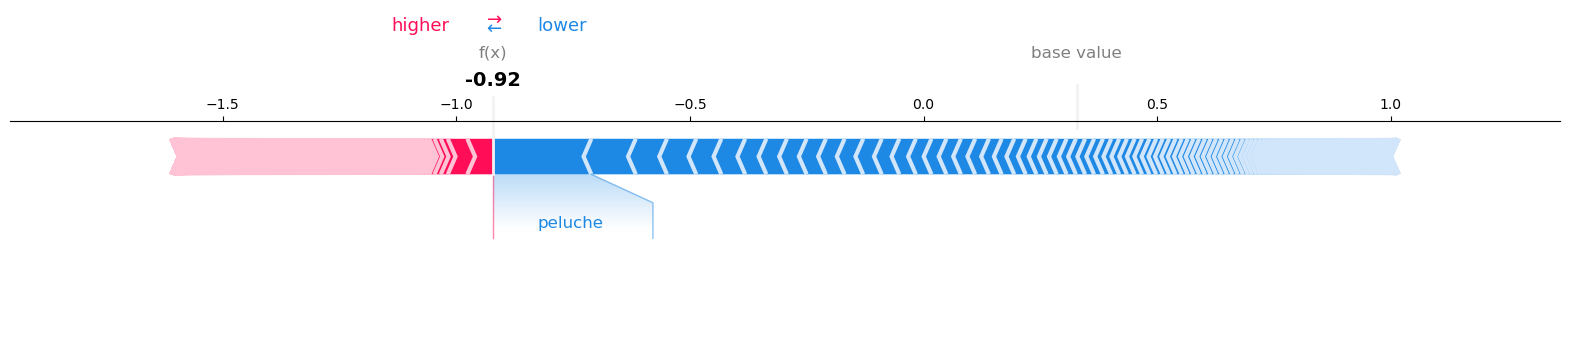

In [24]:
shap.initjs()
shap.force_plot(explainer_lrc.expected_value[6], shap_val_lrc.values[15,:,6], feature_names = feature_names,
                matplotlib=True)

Un article appartenant à la classe 1280 - jouets, peluches, poupées : illustration d’un force plot pour une classe erronée (1180 - figurines collectionnables pour jeu de société).
Le graphique montre clairement un score de sortie inférieur à la valeur de base, avec des contributions des caractéristiques (features, e.g. 'peluche') qui abaissent le score pour cette classe.

In [87]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[248]], "\n\n")

print("Class attribué :", "\n")
print(labels.iloc[3])

Reel class : 

prdtypecode_label    consoles de jeux video
Name: 60, dtype: object 


Class attribué : 

prdtypecode_label    consoles de jeux video
Name: 60, dtype: object


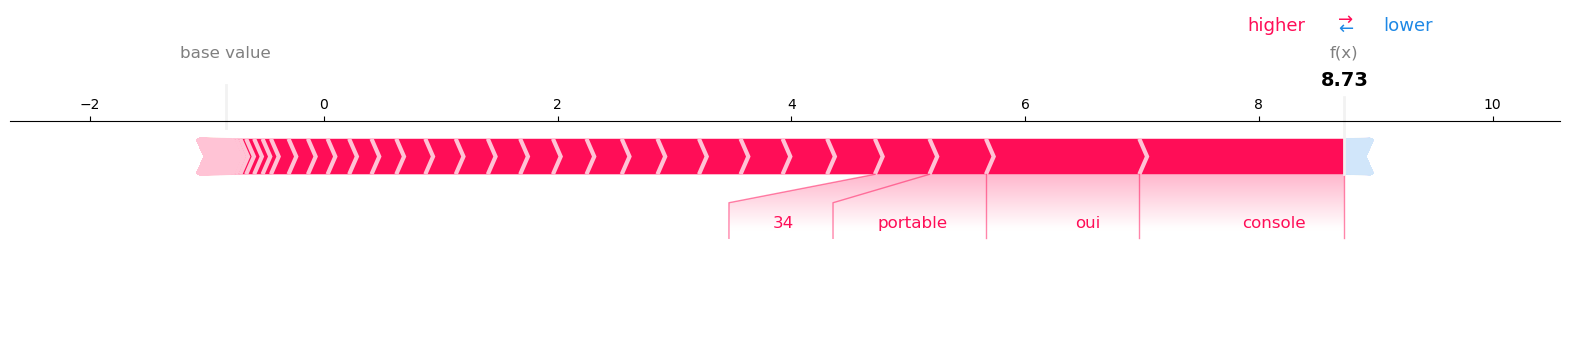

In [27]:
## Most Confident Prediction
shap.initjs()
shap.force_plot(explainer_lrc.expected_value[3], shap_val_lrc.values[248,:,3], feature_names = feature_names,
                matplotlib=True)

Le force plot SHAP présenté ci-dessus illustre les contributions individuelles des caractéristiques au score de sortie du modèle pour la classe prédite, concernant l’article pour lequel la probabilité de prédiction est la plus élevée par le modèle régression logistique. Parmi toutes les caractéristiques, les variables 'console', 'oui', 'portable' et '34' jouent un rôle majeur en augmentant significativement ce score, ce qui explique en grande partie la confiance du modèle dans cette prédiction.

In [86]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[413]], "\n\n")

print("Class attribué :", "\n")
print(labels.iloc[8])

Reel class : 

prdtypecode_label    accessoires petite enfance
Name: 1320, dtype: object 


Class attribué : 

prdtypecode_label    jeux de société
Name: 1281, dtype: object


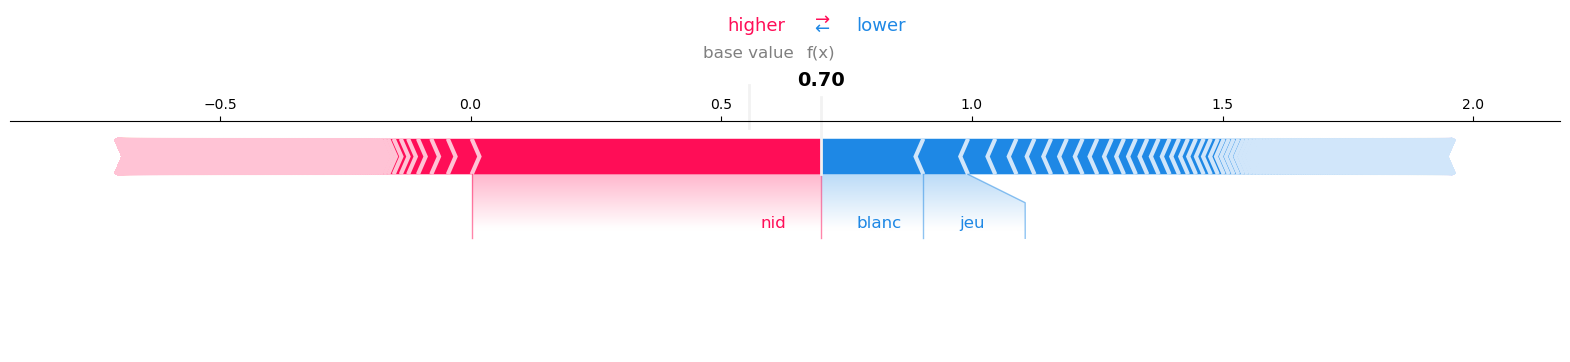

In [31]:
## Least Confident Prediction
shap.initjs()
shap.force_plot(explainer_lrc.expected_value[8], shap_val_lrc.values[413,:,8], feature_names = feature_names,
                matplotlib=True)

Le force plot SHAP présenté ci-dessus met en évidence la contribution de chaque caractéristique au score de sortie du modèle pour la classe prédite (1281 - jeux de société) concernant cet article. Cette prédiction correspond à celle pour laquelle le modèle de régression logistique a la plus faible confiance, parmi les jeux de données utilisés. Ce graphique illustre clairement une erreur de classification, puisque l’article appartient en réalité à la classe 1320 - accessoires petite enfance, ce qui montre comment les caractéristiques ont influencé incorrectement la décision du modèle.

In [66]:
print(labels.iloc[12])

prdtypecode_label    accessoires petite enfance
Name: 1320, dtype: object


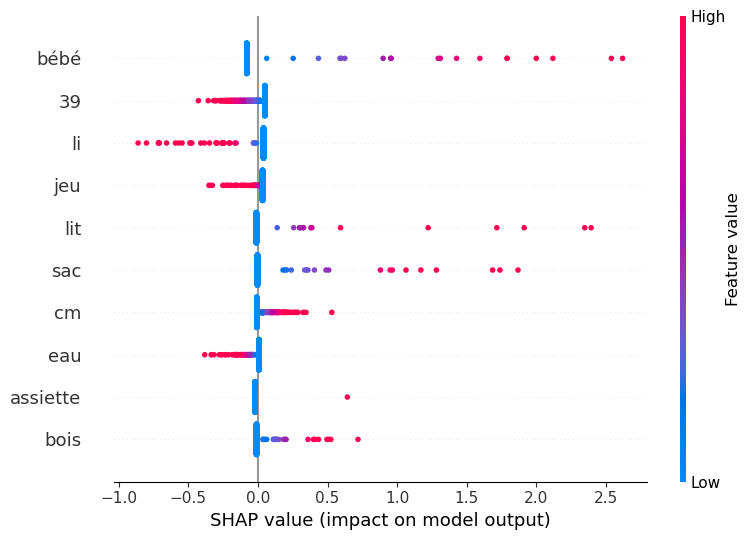

In [9]:
shap.summary_plot(shap_val_lrc.values[:, :, 12], X_test_sample, max_display = 10)

Summary plot pour la classe 1320 – accessoires petite enfance, limité aux 10 principales caractéristiques.
Ce graphique montre comment les différentes caractéristiques influencent la probabilité que l’article appartienne à cette classe. Les valeurs élevées des caractéristiques 'bébé', 'lit', 'sac', 'cm' et 'bois' augmentent la probabilité de prédiction pour cette classe, tandis que des valeurs élevées des caractéristiques '39', 'li', 'jeu' et 'eau' la diminuent.

In [67]:
print(labels.iloc[10])

prdtypecode_label    accesoires et jeux pour petits enfants/bébés
Name: 1301, dtype: object


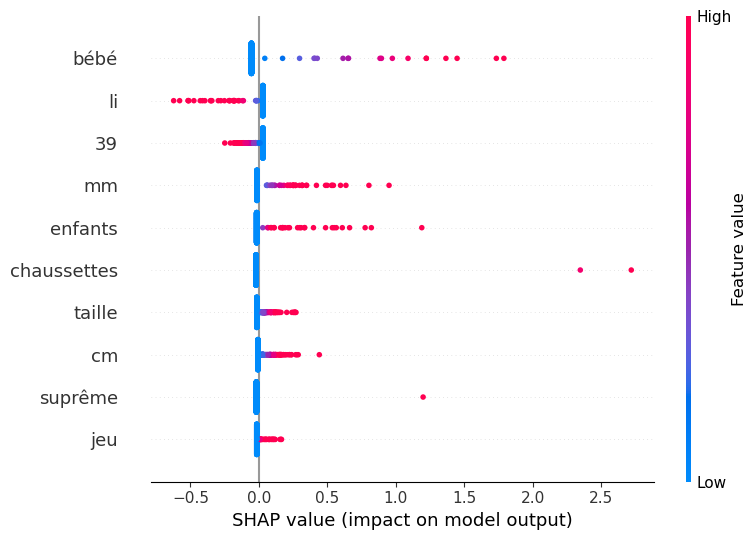

In [39]:
# Highest F1 score
shap.summary_plot(shap_val_lrc.values[:, :, 10], X_test_sample, max_display = 10)

De la même manière que pour la classe précédente, la classe 1301 - accesoires et jeux pour petits enfants/bébés, voit sa probabilité augmenter avec des valeurs élevées des caractéristiques telles que 'bébé' and 'cm' en plus de 'mm', 'enfants', 'taille', et 'jeu', tandis que la probabilité diminue avec les caractéristiques 'li' et '39'.

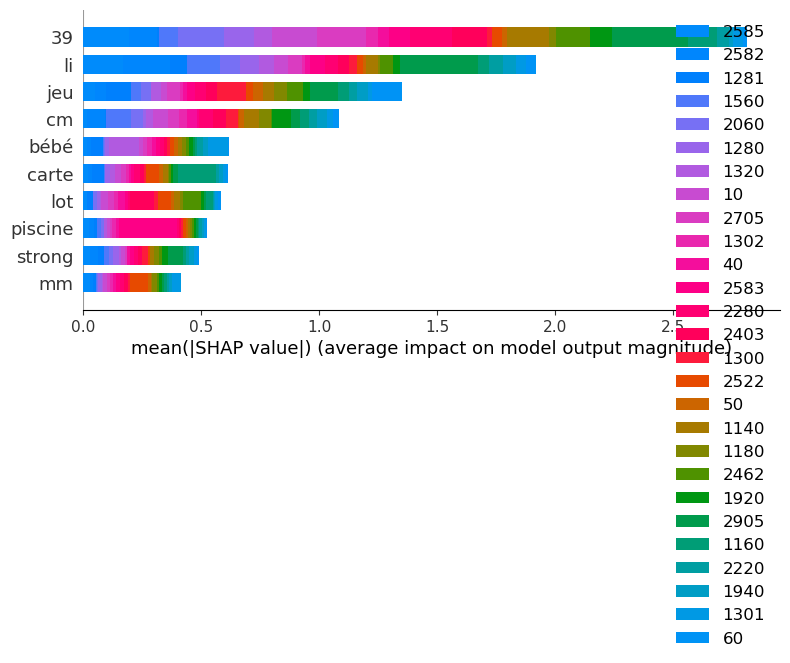

In [43]:
shap.summary_plot(shap_val_lrc.values, X_test_sample, max_display = 10, plot_type="bar", class_names = class_names)

## Random Forest SHAP by TreeExplainer

In [11]:
explainer_rf = shap.TreeExplainer(rfc, data=X_train_sample)
shap_val_rf = explainer_rf(X_test_sample)


100%|===================| 13489/13500 [10:24<00:00]        

In [32]:
probs_rf = rfc.predict_proba(X_test_sample)  # shape: (n_samples, n_classes)

# Pick the sample with the highest max probability
confidences_rf = probs_rf.max(axis=1)
most_confident_idx_rf = np.argmax(confidences_rf)

print("Most confident prediction:", confidences_rf[most_confident_idx_rf])
print("Most confident sample index:", most_confident_idx_rf)
print("Most confident sample's class:", np.argmax(probs_rf[most_confident_idx_rf]))


# lowest confidence
print("Least confident sample index:", np.argmin(confidences_rf))
print("Least confident sample's class:", np.argmax(probs_rf[np.argmin(confidences_rf)]))

C:\Users\Cansu\miniconda3\envs\dsproject\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Most confident prediction: 0.9958105263157894
Most confident sample index: 248
Most confident sample's class: 3
Least confident sample index: 413
Least confident sample's class: 15


In [70]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[15]], "\n\n")

print("Class verifié avec force plot :", "\n")
print(labels.iloc[6])

Reel class : 

prdtypecode_label    jouets, peluches, poupées
Name: 1280, dtype: object 


Class verifié avec force plot : 

prdtypecode_label    figurines collectionnables pour jeu de société
Name: 1180, dtype: object


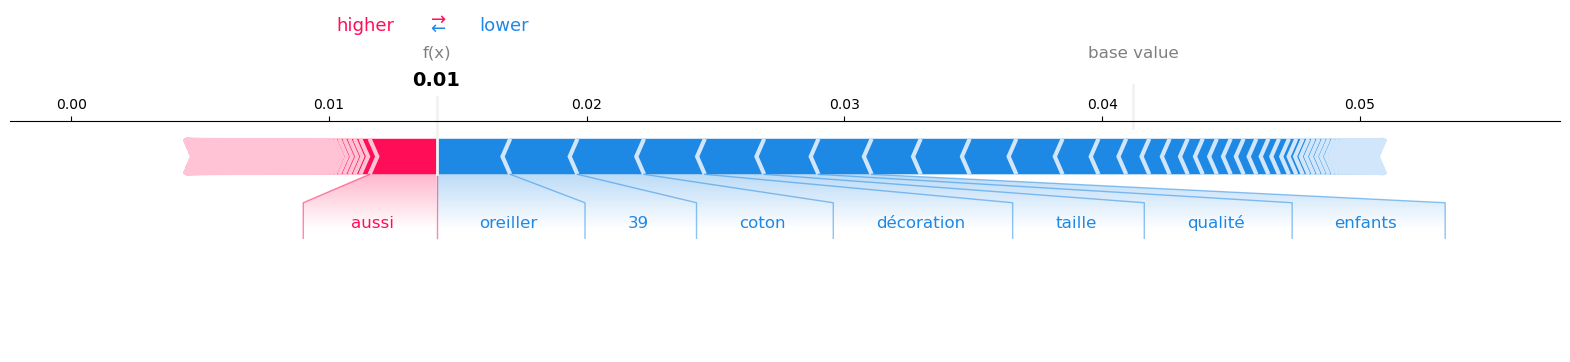

In [12]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[6], shap_val_rf.values[15,:,6], feature_names = feature_names,
                matplotlib=True)

Un article appartenant à la classe 1280 - jouets, peluches, poupées : illustration d’un force plot pour une classe erronée 1180 - figurines collectionnables pour jeu de société.
Le graphique met en évidence un score de sortie inférieur à la valeur de base (baseline), ce qui signifie que la probabilité prédite pour la classe 1180 est plus faible que la moyenne. Les contributions des caractéristiques ('oreiller', '39', 'coton', 'décoration', 'taille') poussent ce score vers le bas, tandis que la caractéristique 'aussi' agit en sens inverse en augmentant le score. Ce force plot illustre comment les différentes caractéristiques influencent la prédiction pour cette classe erronée choisie dans un classificateur random forest entraîné.

In [85]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[248]], "\n\n")

print("Class attribué :", "\n")
print(labels.iloc[3])

Reel class : 

prdtypecode_label    consoles de jeux video
Name: 60, dtype: object 


Class attribué : 

prdtypecode_label    consoles de jeux video
Name: 60, dtype: object


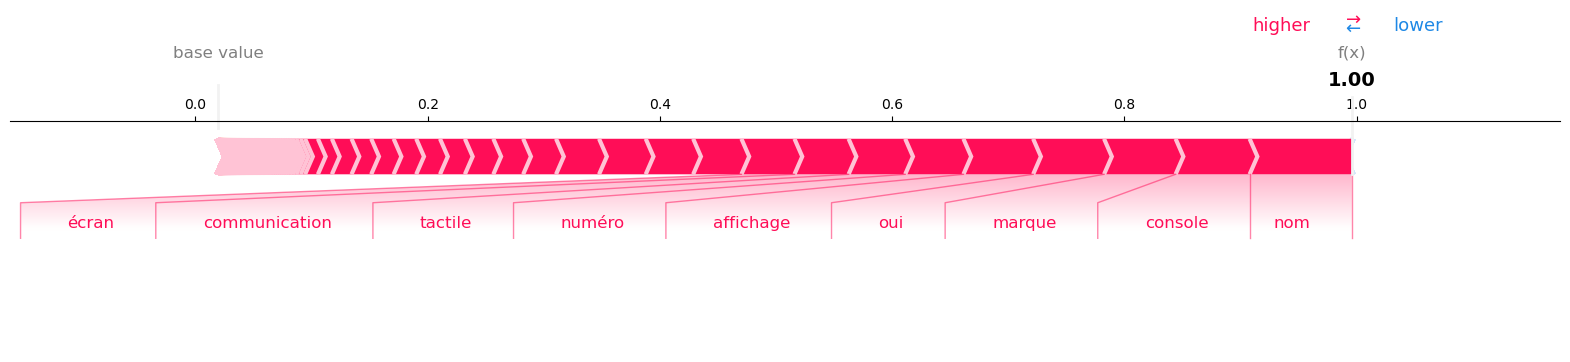

In [33]:
### Most confident 
shap.initjs()
shap.force_plot(explainer_rf.expected_value[3], shap_val_rf.values[248,:,3], feature_names = feature_names,
                matplotlib=True)

Le force plot ci-dessus illustre un article appartenant à la classe 60 - consoles de jeux video, dont la classification correcte a été attribuée avec la plus grande confiance. Parmi les caractéristiques, 'nom', 'console', 'marque', 'oui', 'affichage', 'numéro', 'tactile', 'communication' et 'écran' ont fortement contribué à augmenter le score de sortie du modèle pour cette classe, ce qui explique la confiance élevée dans cette prédiction.

In [84]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[413]], "\n\n")

print("Class attribué :", "\n")
print(labels.iloc[15])

Reel class : 

prdtypecode_label    accessoires petite enfance
Name: 1320, dtype: object 


Class attribué : 

prdtypecode_label    nourriture
Name: 1940, dtype: object


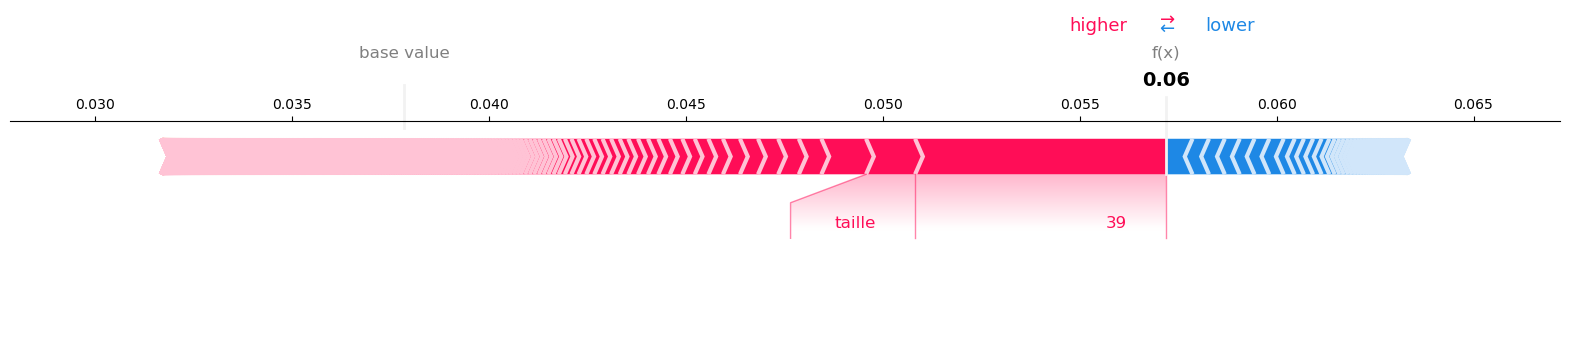

In [34]:
### Least confident

shap.initjs()
shap.force_plot(explainer_rf.expected_value[15], shap_val_rf.values[413,:,15], feature_names = feature_names,
                matplotlib=True)

L’article illustré dans le force plot, attribué à une classe par un classificateur random forest, présente un score de sortie supérieur à la valeur de base (baseline) pour la classe prédite. Cependant, il a été mal classé dans la classe 1940-nourriture, alors qu’il appartient réellement à la classe 1320 - accessoires petite enfance. Les caractéristiques '39' et 'taille' jouent un rôle important en augmentant ce score, ce qui a conduit le modèle à favoriser cette prédiction erronée. Ce graphique met en lumière comment certaines caractéristiques peuvent influencer de manière significative la décision du modèle, même lorsque celle-ci ne correspond pas à la vérité.

In [73]:
print(labels.iloc[12])

prdtypecode_label    accessoires petite enfance
Name: 1320, dtype: object


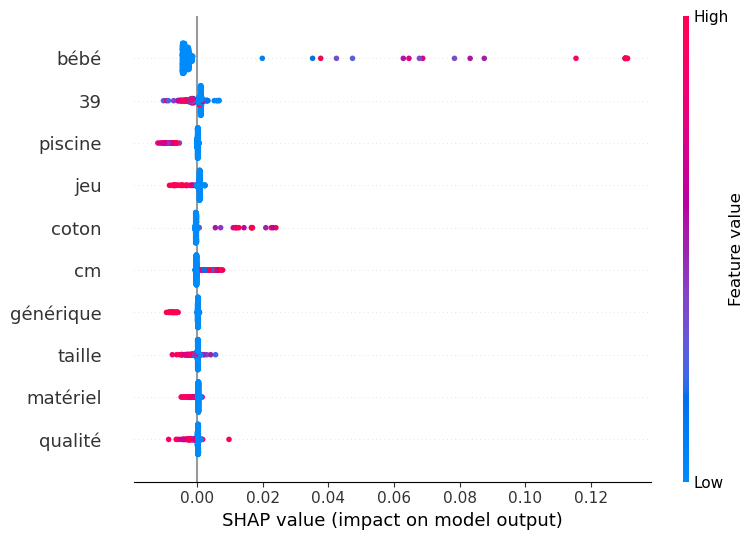

In [13]:
shap.summary_plot(shap_val_rf.values[:, :, 12], X_test_sample, max_display = 10)

Le classificateur random forest utilise un ensemble de caractéristiques pour prédire la classe sélectionnée (1320 - accessoires petite enfance). Ici, le summary plot est limité aux 10 caractéristiques les plus influentes. On observe que les caractéristiques 'bébé' et 'coton' ont des valeurs SHAP positives élevées, ce qui signifie qu’elles augmentent la probabilité que l’article appartienne à cette classe. En revanche, les caractéristiques '39', 'piscine', 'jeu', 'générique', 'taille', 'matériel' et 'qualité' ont des valeurs SHAP négatives, indiquant qu’elles diminuent cette probabilité. Ce summary plot permet de visualiser l’impact global des caractéristiques les plus importantes sur la prédiction pour cette classe.

In [74]:
print(labels.iloc[26])

prdtypecode_label    jeux en téléchargement
Name: 2905, dtype: object


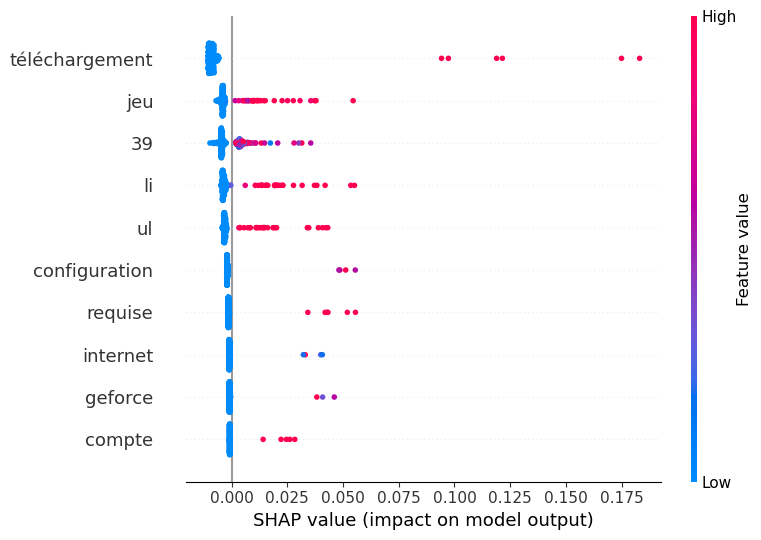

In [40]:
# Highest F1 score
shap.summary_plot(shap_val_rf.values[:, :, 26], X_test_sample, max_display = 10)

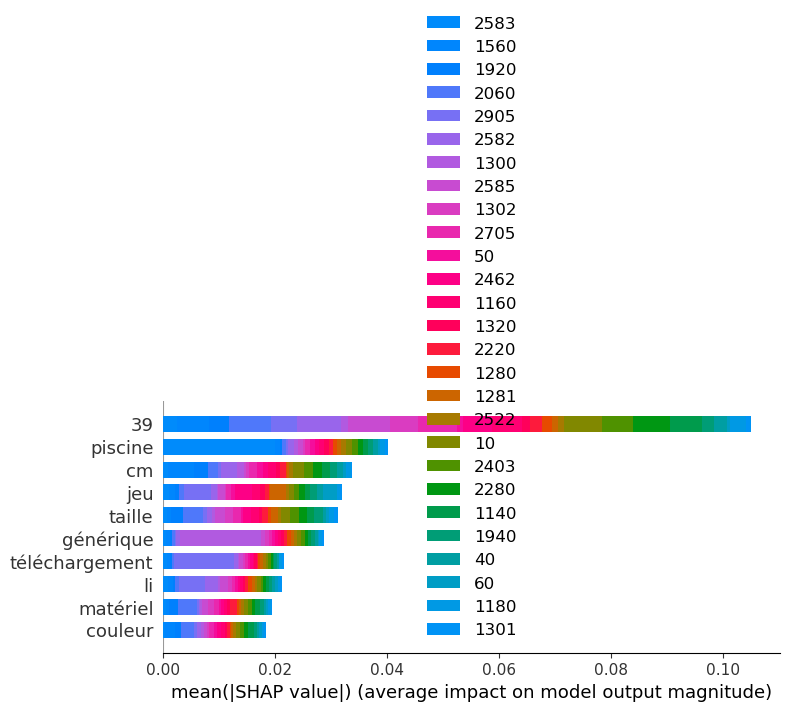

In [14]:
shap.summary_plot(shap_val_rf.values, X_test_sample, max_display = 10, plot_type="bar", class_names = class_names)

## XGBoost SHAP by TreeExplainer

In [15]:
explainer_xgb = shap.TreeExplainer(xgb, data=X_train_sample)
shap_val_xgb = explainer_xgb(X_test_sample)


100%|===================| 13473/13500 [07:42<00:00]        

In [35]:
probs_xgb = xgb.predict_proba(X_test_sample)  # shape: (n_samples, n_classes)

# Pick the sample with the highest max probability
confidences_xgb = probs_xgb.max(axis=1)
most_confident_idx_xgb = np.argmax(confidences_xgb)

print("Most confident prediction:", confidences_xgb[most_confident_idx_xgb])
print("Most confident sample index:", most_confident_idx_xgb)
print("Most confident sample's class:", np.argmax(probs_xgb[most_confident_idx_xgb]))


# lowest confidence
print("Least confident sample index:", np.argmin(confidences_xgb))
print("Least confident sample's class:", np.argmax(probs_xgb[np.argmin(confidences_xgb)]))

C:\Users\Cansu\miniconda3\envs\dsproject\Lib\site-packages\xgboost\data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


Most confident prediction: 0.3853207
Most confident sample index: 396
Most confident sample's class: 5
Least confident sample index: 280
Least confident sample's class: 10


In [75]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[15]], "\n\n")

print("Class verifié avec force plot :", "\n")
print(labels.iloc[6])

Reel class : 

prdtypecode_label    jouets, peluches, poupées
Name: 1280, dtype: object 


Class verifié avec force plot : 

prdtypecode_label    figurines collectionnables pour jeu de société
Name: 1180, dtype: object


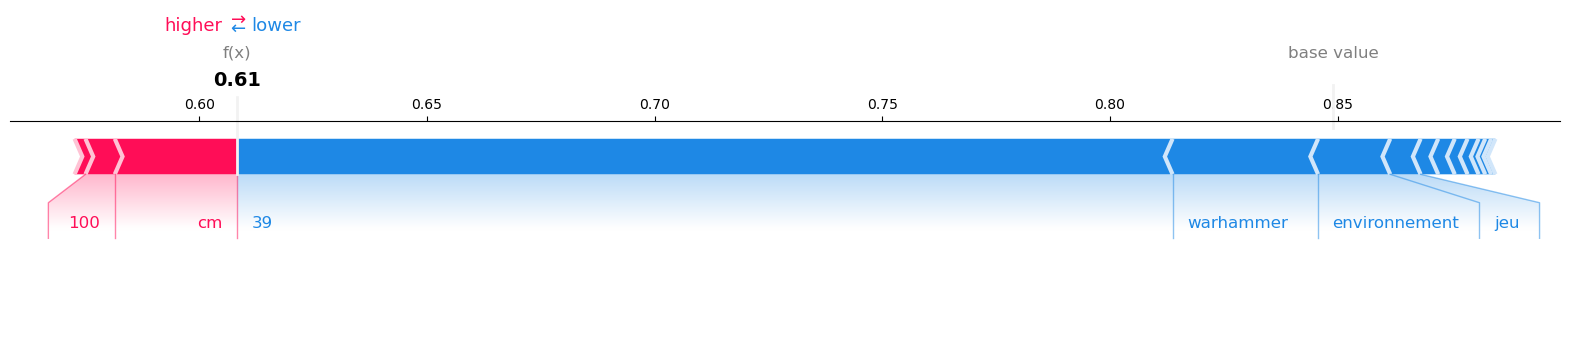

In [16]:
shap.initjs()
shap.force_plot(explainer_xgb.expected_value[6], shap_val_xgb.values[15,:,6], feature_names = feature_names,
                matplotlib=True)

#shap.force_plot(
#    explainer.expected_value[class_idx],               # baseline for that class
#    shap_values.values[sample_idx, :, class_idx],      # SHAP values for that sample & class
#    features=X_test_df.iloc[sample_idx],                # feature values for that sample
#    feature_names=feature_names                         # optional, usually inferred from DataFrame
#)

In [81]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[396]], "\n\n")

print("Class attribué :", "\n")
print(labels.iloc[5])

Reel class : 

prdtypecode_label    cartes collectionables
Name: 1160, dtype: object 


Class attribué : 

prdtypecode_label    cartes collectionables
Name: 1160, dtype: object


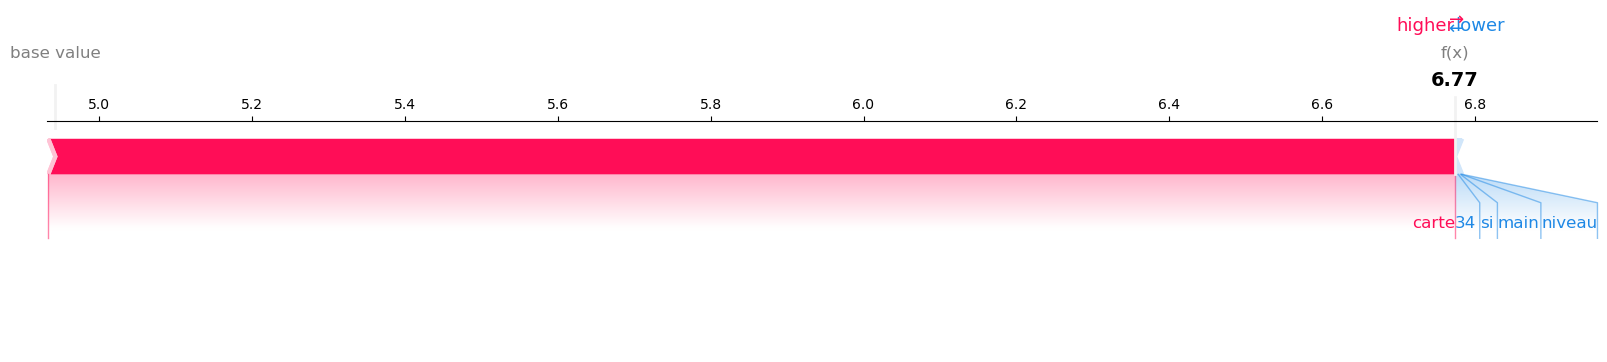

In [36]:
### Most confident
shap.initjs()
shap.force_plot(explainer_xgb.expected_value[5], shap_val_xgb.values[396,:,5], feature_names = feature_names,
                matplotlib=True)

In [80]:
print("Reel class :", "\n")
print(labels.loc[y_test_sample.iloc[280]], "\n\n")

print("Class attribué :", "\n")
print(labels.iloc[10])

Reel class : 

prdtypecode_label    voitures miniatures et maquettes
Name: 1300, dtype: object 


Class attribué : 

prdtypecode_label    accesoires et jeux pour petits enfants/bébés
Name: 1301, dtype: object


C:\Users\Cansu\miniconda3\envs\dsproject\Lib\site-packages\shap\plots\_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


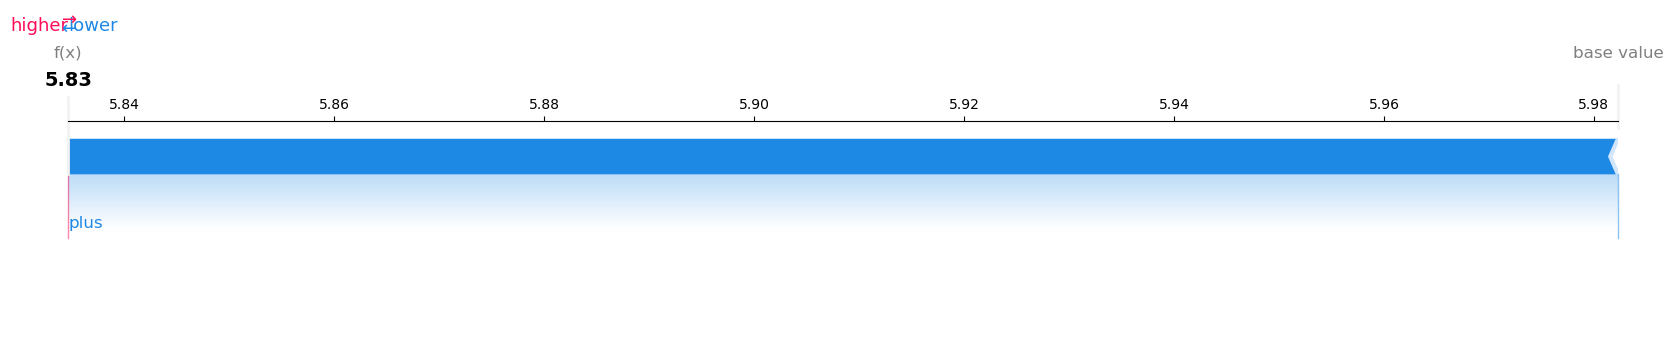

In [37]:
### Least confident
shap.initjs()
shap.force_plot(explainer_xgb.expected_value[10], shap_val_xgb.values[280,:,10], feature_names = feature_names,
                matplotlib=True)

In [82]:
print(labels.iloc[12])

prdtypecode_label    accessoires petite enfance
Name: 1320, dtype: object


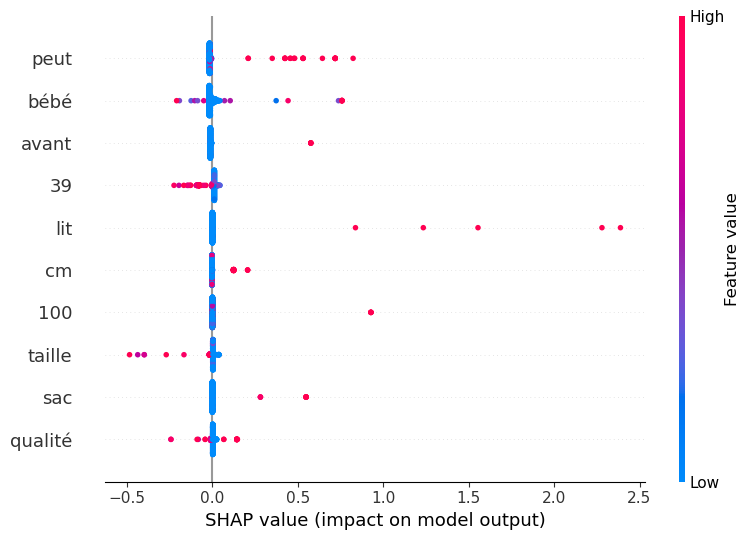

In [17]:
shap.summary_plot(shap_val_xgb.values[:, :, 12], X_test_sample, max_display = 10)

In [83]:
print(labels.iloc[26])

prdtypecode_label    jeux en téléchargement
Name: 2905, dtype: object


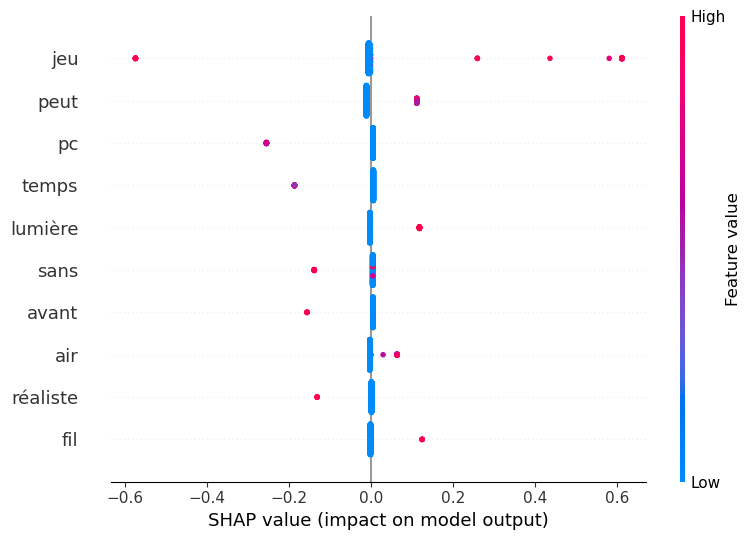

In [41]:
# Highest F1 score

shap.summary_plot(shap_val_xgb.values[:, :, 26], X_test_sample, max_display = 10)

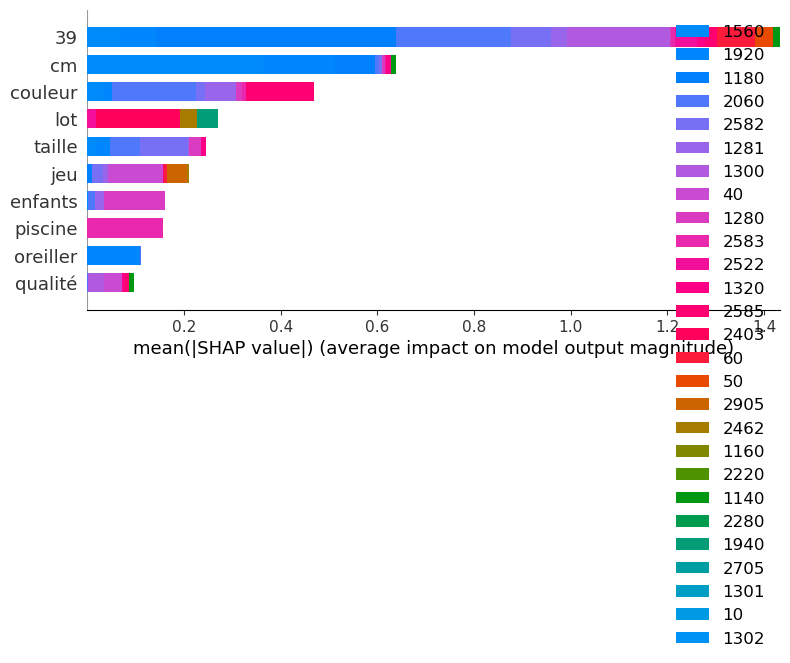

In [18]:
shap.summary_plot(shap_val_xgb.values, X_test_sample, max_display = 10, plot_type="bar", class_names = class_names)